## Testing on Refind Data

In [1]:
import os
import random
from dotenv import load_dotenv

from typing import Annotated, List, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, conlist

import operator

from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command
from langgraph.graph.message import add_messages

from langgraph.checkpoint.memory import MemorySaver

from langchain_openai import ChatOpenAI


from IPython.display import display, Markdown, Image

from langchain_community.document_loaders import RSSFeedLoader

from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
)

import pandas as pd

from tqdm.notebook import tqdm

In [2]:
MODEL = "google_genai:gemini-2.0-flash-001"  # "openai:gpt-4o-mini"

In [3]:
load_dotenv("../.env")

False

In [4]:
os.environ["LANGCHAIN_PROJECT"] = "AgentXSyntheticNShotGemini_Semeval_task8"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"

In [5]:
df = pd.read_csv("./../../../projects/active_learning_project/data/semeval_2010_task8_data/csv_files/test.csv")
df.head()

,sentence,relation,label,entity1,entity2,sentence_without_tags,split
0,The most common <e1>audits</e1> were about <e2...,"Message-Topic (e1, e2)",14,audits,waste,The most common audits were about waste and re...,test
1,The <e1>company</e1> fabricates plastic <e2>ch...,"Product-Producer (e2, e1)",17,company,chairs,The company fabricates plastic chairs.,test
2,The school <e1>master</e1> teaches the lesson ...,"Instrument-Agency (e2, e1)",11,master,stick,The school master teaches the lesson with a st...,test
3,The suspect dumped the dead <e1>body</e1> into...,"Entity-Destination (e1, e2)",6,body,reservoir,The suspect dumped the dead body into a local ...,test
4,Avian <e1>influenza</e1> is an infectious dise...,"Cause-Effect (e2, e1)",1,influenza,virus,Avian influenza is an infectious disease of bi...,test


In [6]:
all_relations = df['relation'].unique().tolist()
print(all_relations)

['Message-Topic (e1, e2)', 'Product-Producer (e2, e1)', 'Instrument-Agency (e2, e1)', 'Entity-Destination (e1, e2)', 'Cause-Effect (e2, e1)', 'Component-Whole (e1, e2)', 'Product-Producer (e1, e2)', 'Member-Collection (e2, e1)', 'Other', 'Entity-Origin (e1, e2)', 'Content-Container (e1, e2)', 'Entity-Origin (e2, e1)', 'Cause-Effect (e1, e2)', 'Component-Whole (e2, e1)', 'Content-Container (e2, e1)', 'Instrument-Agency (e1, e2)', 'Message-Topic (e2, e1)', 'Member-Collection (e1, e2)', 'Entity-Destination (e2, e1)']


In [ ]:
# structured output Data Models
class SelectedLabels(BaseModel):
    labels: List["str"]  # add something to limit number of selected labels, check later

class GeneratedExample(BaseModel):
    context: str
    head_entity: str
    tail_entity: str
    label: Literal[
        'Message-Topic (e1, e2)', 'Product-Producer (e2, e1)', 'Instrument-Agency (e2, e1)', 'Entity-Destination (e1, e2)', 'Cause-Effect (e2, e1)', 'Component-Whole (e1, e2)', 'Product-Producer (e1, e2)', 'Member-Collection (e2, e1)', 'Other', 'Entity-Origin (e1, e2)', 'Content-Container (e1, e2)', 'Entity-Origin (e2, e1)', 'Cause-Effect (e1, e2)', 'Component-Whole (e2, e1)', 'Content-Container (e2, e1)', 'Instrument-Agency (e1, e2)', 'Message-Topic (e2, e1)', 'Member-Collection (e1, e2)', 'Entity-Destination (e2, e1)'
    ]

class GeneratedExamples(BaseModel):
    examples: List[GeneratedExample]

class EvaluateRelationshipOutput(BaseModel):
    output: Literal[
        'Message-Topic (e1, e2)', 'Product-Producer (e2, e1)', 'Instrument-Agency (e2, e1)', 'Entity-Destination (e1, e2)', 'Cause-Effect (e2, e1)', 'Component-Whole (e1, e2)', 'Product-Producer (e1, e2)', 'Member-Collection (e2, e1)', 'Other', 'Entity-Origin (e1, e2)', 'Content-Container (e1, e2)', 'Entity-Origin (e2, e1)', 'Cause-Effect (e1, e2)', 'Component-Whole (e2, e1)', 'Content-Container (e2, e1)', 'Instrument-Agency (e1, e2)', 'Message-Topic (e2, e1)', 'Member-Collection (e1, e2)', 'Entity-Destination (e2, e1)'
    ]

In [8]:
# state for input
class InputState(TypedDict):
    context : str
    entity_1 : str
    entity_2 : str
    list_of_labels : List[str]
    selected_labels : SelectedLabels 
    negative_examples : GeneratedExamples
    positive_examples : GeneratedExamples
    # max_num_of_revisions : int
    label : EvaluateRelationshipOutput

In [40]:
label_direction_related_info = "In labels (e1, e2) defines the direction of the relation between the entities."

In [41]:
def select_helpful_labels_for_n_shot(state: InputState):
    llm = init_chat_model(
        model=MODEL,
        temperature=0.2
    ).with_structured_output(SelectedLabels)

    out = llm.invoke(
        [
            SystemMessage(
                content=f"You are a helpful assistant. You will be given a text with entities and a list of labels. Select labels from the list of labels. Selected labels should be such that generated positive and negative examples using these labels will be useful in doing N Shot Classification. {label_direction_related_info} In short, the model will be able to get confused between these selected labels while answering. Provide the output in a JSON format."
            ),
            HumanMessage(
                content=f"Labels: {state['list_of_labels']}\nContext: {state['context']}\n Head Entity: {state['entity_1']}\n Tail Entity: {state['entity_2']}"
            )
        ]
    )
    return {
        "selected_labels": out.labels
    }

def generate_positive_example(state: InputState):
    """Generate a positive example for the given text, entities and label."""
    positive_example_llm = init_chat_model(
        model=MODEL,
        temperature=0.4,
    ).with_structured_output(GeneratedExamples)

    out = positive_example_llm.invoke(
        [
            SystemMessage(
                content=f"You are a helpful assistant that generates examples for relationship classification task. You will be given a text with entities and a list of labels. Generate positive examples with context and entities similar to what is provided. Generate an example for each label. {label_direction_related_info} Provide the output in a JSON format."
            ),
            HumanMessage(
                content=f"Labels: {state['selected_labels']}\nContext: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            )
        ]
    )
    
    return {
        "positive_examples": out.examples
    }


def generate_negative_example(state: InputState):
    """Generate a negative example for the given text, entities and label."""
    negative_example_llm = init_chat_model(
        model=MODEL,
        temperature=0.4,
    ).with_structured_output(GeneratedExamples)

    out = negative_example_llm.invoke(
        [
            SystemMessage(
                content=f"You are a evil assistant that generates examples for relationship classification task. You will be given a text with entities and a list of labels. Generate negative examples with context and entities similar to what is provided. Generate an example for each label. The generated examples should be such that they could fool a naive classifier. {label_direction_related_info} Provide the output in a JSON format."
            ),
            HumanMessage(
                content=f"Labels: {state['selected_labels']}\nContext: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            )
        ]
    )
    return {
        "negative_examples": out.examples
    }

In [42]:
def evaluate_relationship(state: InputState):
    """Evaluate the relationship between the head and tail entities in the text."""
    relationship_evaluator = init_chat_model(
        model=MODEL,
        temperature=0,
    ).with_structured_output(EvaluateRelationshipOutput)
    
    out = relationship_evaluator.invoke(
        [
            SystemMessage(
                content=f"You are a helpful assistant that identifies the relationship between two entities given a context. You will be given a context, and a pair of entities and a list of possible labels. You will also be given positive examples and negative examples for each similar labels for better understanding. Provide the answer in a JSON format. The output should be the label that best describes the relationship between the entities in the context. {label_direction_related_info}"
            ),
            HumanMessage(
                content=f"List of Labels: \n {state['list_of_labels']} \n\n Positive Examples : \n{state['positive_examples']}\n\n Negative Examples:\n {state['negative_examples']}\n\n Context: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            ),
        ]
    )
    
    return {
        "label": out.output
    }
    

# def to_revise_or_not(state: InputState):
#     """Decide whether to revise the generated examples or not."""
#     if state["max_num_of_revisions"] <= 0:
#         return "revision_limit_reached"
    
#     llm = init_chat_model(
#         model="openai:gpt-4o-mini",
#         temperature=0,
#     )

#     out = llm.invoke(
#         [
#             SystemMessage(
#                 content="You are a helpful assistant that decides whether to revise the generated examples or not. You will be given a context, head entity, tail entity, predicted label. You will also be given positive examples and negative examples that were used to get the predicted label. Decide whether the predicted label is correct or not. Provide the answer in a JSON format."
#             ),
#             HumanMessage(
#                 content=f"List of Labels: \n {state['list_of_labels']} \n\n Positive Examples : \n{state['positive_examples']}\n\n Negative Examples:\n {state['negative_examples']}\n\n Context: {state['context']}\n Head Entity: {state['head_entity']}\n Tail Entity: {state['tail_entity']}"
#             ),
#         ]
#     )
    
#     return {
#         "max_num_of_revisions": state["max_num_of_revisions"] + 1
#     }

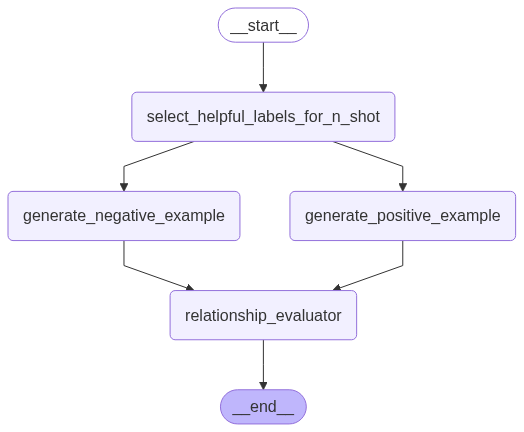

In [43]:
graph_builder = StateGraph(InputState)

graph_builder.add_node("select_helpful_labels_for_n_shot", select_helpful_labels_for_n_shot)
graph_builder.add_node("generate_positive_example", generate_positive_example)  
graph_builder.add_node("generate_negative_example", generate_negative_example)
graph_builder.add_node("relationship_evaluator", evaluate_relationship)

graph_builder.add_edge(START, "select_helpful_labels_for_n_shot")
graph_builder.add_edge("select_helpful_labels_for_n_shot", "generate_positive_example")
graph_builder.add_edge("select_helpful_labels_for_n_shot", "generate_negative_example")

graph_builder.add_edge(
    ["generate_positive_example", "generate_negative_example"],
    "relationship_evaluator",
)
graph_builder.add_edge("relationship_evaluator", END)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
df.iloc[147]

sentence                 Roadside <e1>attractions</e1> are frequently a...
relation                                            Message-Topic (e2, e1)
label                                                                   15
entity1                                                        attractions
entity2                                                         billboards
sentence_without_tags    Roadside attractions are frequently advertised...
split                                                                 test
Name: 147, dtype: object

In [45]:
text = df.iloc[147]['sentence_without_tags']
head_entity = df.iloc[147]['entity1']
tail_entity = df.iloc[147]["entity2"]

In [49]:
text, head_entity, tail_entity

('Roadside attractions are frequently advertised with billboards to attract tourists.',
 'attractions',
 'billboards')

In [56]:
input_data = {
    "context": text,
    "entity_1": head_entity,
    "entity_2": tail_entity,
    "list_of_labels": all_relations,
}

result = graph.invoke(input_data)

In [57]:
result["label"]

'Other'

In [15]:
answers = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    text = row['sentence_without_tags']
    head_entity = row['entity1']
    tail_entity = row['entity2']
    try : 
        input_data = {
            "context": text,
            "head_entity": head_entity,
            "tail_entity": tail_entity,
            "list_of_labels": all_relations,
        }
        
        result = graph.invoke(input_data)
        
        answers.append(result["label"])
    except Exception as e:
        answers.append(None)
        continue
    

  0%|          | 0/2717 [00:00<?, ?it/s]

In [58]:
df["predicted_label"] = answers

NameError: name 'answers' is not defined

In [59]:
df.isnull().sum()

sentence                 0
relation                 0
label                    0
entity1                  0
entity2                  0
sentence_without_tags    0
split                    0
dtype: int64

In [30]:
df = df[~df.predicted_label.isnull()]
df.shape

(2716, 8)

In [32]:
from sklearn.metrics import classification_report

# Assuming your predictions and ground truths are stored in lists:
# predictions = [...]
# ground_truths = [...]

print(classification_report(df.relation, df.predicted_label, labels=all_relations))

                             precision    recall  f1-score   support

     Message-Topic (e1, e2)       0.39      0.80      0.52       210
  Product-Producer (e2, e1)       0.16      0.04      0.07       122
 Instrument-Agency (e2, e1)       0.71      0.22      0.34       134
Entity-Destination (e1, e2)       0.71      0.27      0.39       291
      Cause-Effect (e2, e1)       0.82      0.24      0.37       194
   Component-Whole (e1, e2)       0.33      0.36      0.35       162
  Product-Producer (e1, e2)       0.19      0.13      0.15       108
 Member-Collection (e2, e1)       0.33      0.02      0.05       201
                      Other       0.28      0.58      0.38       454
     Entity-Origin (e1, e2)       0.73      0.15      0.25       211
 Content-Container (e1, e2)       0.46      0.73      0.56       153
     Entity-Origin (e2, e1)       0.00      0.00      0.00        47
      Cause-Effect (e1, e2)       0.47      0.84      0.60       134
   Component-Whole (e2, e1)      